In [1]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
# ---

In [2]:
train_images_dir = Path("/kaggle/input/plastic-bottles-image-dataset/Plastic Bottle Image Dataset/test/images")
train_labels_dir = Path("/kaggle/input/plastic-bottles-image-dataset/Plastic Bottle Image Dataset/test/labels")

In [3]:
train_images = os.listdir(train_images_dir)
train_labels = os.listdir(train_labels_dir)

## view random samples of the data

Text(0.5, 0.98, 'random samples')

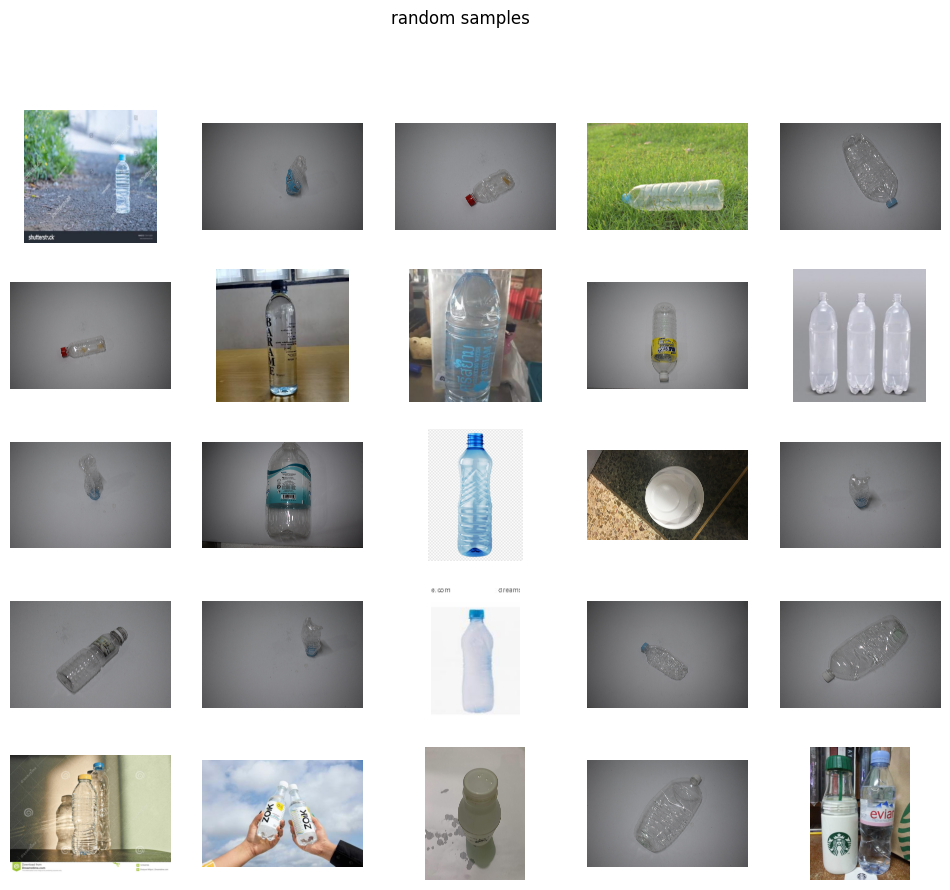

In [4]:
samples = torch.randperm(len(train_images))
nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,10))

for i in range(nrows):
    for j in range(ncols):
        img = Image.open(os.path.join(train_images_dir, train_images[samples[i] + j]))
        axs[i, j].imshow(img)
        axs[i, j].axis(False)
        
plt.suptitle("random samples")

## make labels dataframe

In [5]:
def get_labels(labels_dir):
    """
        # get the labels
    """
    labels = os.listdir(labels_dir)

    image_id = []
    class_id = []
    x_center = []
    y_center = []
    width = []
    height = []
    weird_labels = []
    
    # open the labels in the label path
    print("loading labels ...")
    for i, label in enumerate(labels):
        label_path = os.path.join(labels_dir, label)
        with open(label_path, "r") as f:
            label_file = [line.strip() for line in f]
            for label_sample in label_file:
                try:
                    c, x, y, w, h = label_sample.split(" ")
                    image_id.append(label.replace(".txt", ".jpg"))
                    class_id.append(c)
                    x_center.append(float(x))
                    y_center.append(float(y))
                    width.append(float(w))
                    height.append(float(h))
                except (ValueError):
                    weird_labels.append(label)
                    continue
                    
    print(f"loaded all {i + 1} labels")
            
    return pd.DataFrame({"image_id":image_id,"class": class_id, "x_center":x_center, "y_center":y_center, "width":width, "height":height}), weird_labels # didnt include width, height






def from_YOLO(img_dir, labels_dir):
    """
    Returns the top and bottom corners of object detection labels
    Args:
        img_dir (Path): the images path 
        labels_dir (Path): the labes path

    Returns:
        the top - bottom corners format in a dataframe
        <image_id> <class> <x_min> <y_min> <x_max> <y_max>
    """

    # return the image and labels directories in a list  
    images = os.listdir(img_dir)
    labels = os.listdir(labels_dir)

    img_width = []
    img_height = []
    image_id = []
    
    
    # get images width and height
    for image in images:
        width,height = Image.open(os.path.join(img_dir, image)).size
        img_width.append(width), img_height.append(height), image_id.append(image)

    # dataframe with image heights and widths
    img_prop_df = pd.DataFrame({"image_id":image_id,"img_width":img_width, "img_height":img_height})

    # get labels dataframe
    labels_df, weird_labels = get_labels(labels_dir)

    
    labels_from_labels_df = labels_df["image_id"].values.tolist()
    labels_from_image_prop_df = img_prop_df["image_id"].values.tolist()
    
    img_width = []
    img_height = [] 
    
    for label in labels_from_labels_df:
        for i in range(len(labels_from_image_prop_df)):
            if (label == labels_from_image_prop_df[i]):
                img_width.append(img_prop_df[img_prop_df["image_id"] == label]["img_width"].values.item())
                img_height.append(img_prop_df[img_prop_df["image_id"] == label]["img_height"].values.item())
            
    labels_df["img_width"] = pd.Series(img_width)
    labels_df["img_height"] = pd.Series(img_height)

    # yolo calculations
    labels_df["x_center"] = labels_df["x_center"] * labels_df["img_width"]
    labels_df["y_center"] = labels_df["y_center"] * labels_df["img_height"]
    labels_df["width"] = labels_df["width"] * labels_df["img_width"]
    labels_df["height"] = labels_df["height"] * labels_df["img_height"]
    
    
    # top and bottom corners calculations
    labels_df["x_min"] = labels_df["x_center"] - (labels_df["width"] / 2)
    labels_df["x_max"] = labels_df["x_center"] + (labels_df["width"] / 2)
    labels_df["y_min"] = labels_df["y_center"] - (labels_df["height"] / 2)
    labels_df["y_max"] = labels_df["y_center"] + (labels_df["height"] / 2)

    return labels_df
       

In [6]:
labels_df = from_YOLO(train_images_dir, train_labels_dir)
labels_df

loading labels ...
loaded all 648 labels


,image_id,class,x_center,y_center,width,height,img_width,img_height,x_min,x_max,y_min,y_max
0,bottle-404-_JPG.rf.1a8cf6b8344582315c3d56b0f44...,0,0.000000,1664.800000,2940.00000,68.000000,6000,4000,-1470.000000,1470.000000,1630.800000,1698.800000
1,100011_jpg.rf.259b6675d88d711fdaea5b1b914db954...,0,326.000000,296.000000,209.00000,489.000000,640,640,221.500000,430.500000,51.500000,540.500000
2,bottle-711-_jpg.rf.0839294ca9d48d37790303ae5aa...,0,36.487998,1730.000000,1460.00000,1359.997984,3024,4032,-693.512002,766.487998,1050.001008,2409.998992
3,bottle-216-_JPG.rf.b1695154510c670d225b472d44f...,0,2950.000000,24.800000,1800.00000,1668.000000,6000,4000,2050.000000,3850.000000,-809.200000,858.800000
4,bottle-635-_JPG.rf.a028bbb554183870a9fc46be39e...,0,3760.000000,384.800000,1300.00000,1268.000000,6000,4000,3110.000000,4410.000000,-249.200000,1018.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
772,100045_jpg.rf.594bd6f412147b35e7d9f040c016e946...,0,211.830000,317.460000,140.25000,468.910000,432,576,141.705000,281.955000,83.005000,551.915000
773,9_jpg.rf.347c4d17364cb6299e18456377e85248.jpg,0,521.460000,738.499993,405.99446,1307.000000,1108,1478,318.462770,724.457230,84.999993,1391.999993
774,300015_jpg.rf.d244595dee869da1b715a760d783de73...,0,142.840000,150.000000,134.53000,300.000000,300,300,75.575000,210.105000,0.000000,300.000000
775,bottle-463-_JPG.rf.10f9bb7a0f6f404dec5dbe7cd6f...,0,2800.000000,1914.800000,2420.00000,3048.000000,6000,4000,1590.000000,4010.000000,390.800000,3438.800000


In [7]:
labels_df['image_id'][8]

'-285_jpg.rf.8895570a084a7ec8d5be9a46a5ae2e49.jpg'

In [8]:
x_min, x_max, y_min, y_max, width, height = labels_df[labels_df["image_id"] == '-285_jpg.rf.8895570a084a7ec8d5be9a46a5ae2e49.jpg'][["x_min", "x_max", "y_min","y_max", "width", "height"]].values.tolist()[0]

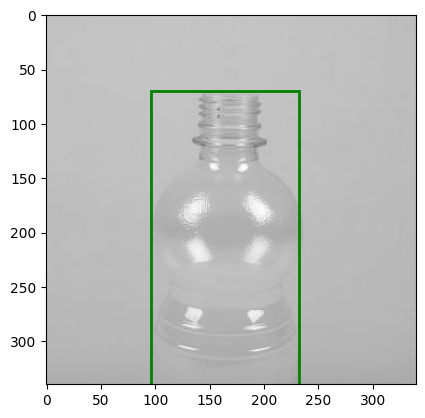

In [9]:
from matplotlib.patches import Rectangle

fig, axs, = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

plt.imshow(Image.open(os.path.join(train_images_dir, '-285_jpg.rf.8895570a084a7ec8d5be9a46a5ae2e49.jpg')))
rect = Rectangle((x_min, y_min), width, height, edgecolor="green", fill=False, linewidth=2)

axs.add_patch(rect)

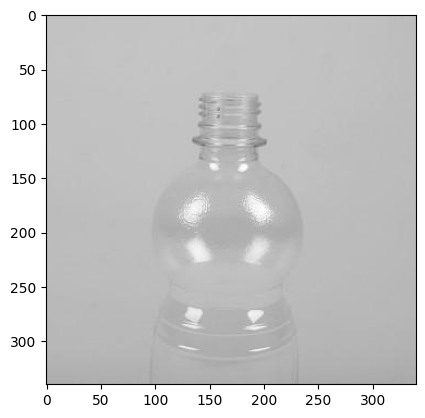

In [10]:
from matplotlib.patches import Rectangle


plt.imshow(Image.open(os.path.join(train_images_dir, '-285_jpg.rf.8895570a084a7ec8d5be9a46a5ae2e49.jpg')))
rect = Rectangle((x_min, y_min), width, height, edgecolor="green", fill=False, linewidth=2)

axs.add_patch(rect)

## plot random images and thier bounding boxes

In [11]:
images = labels_df["image_id"].values.tolist()


Text(0.5, 0.98, 'random samples')

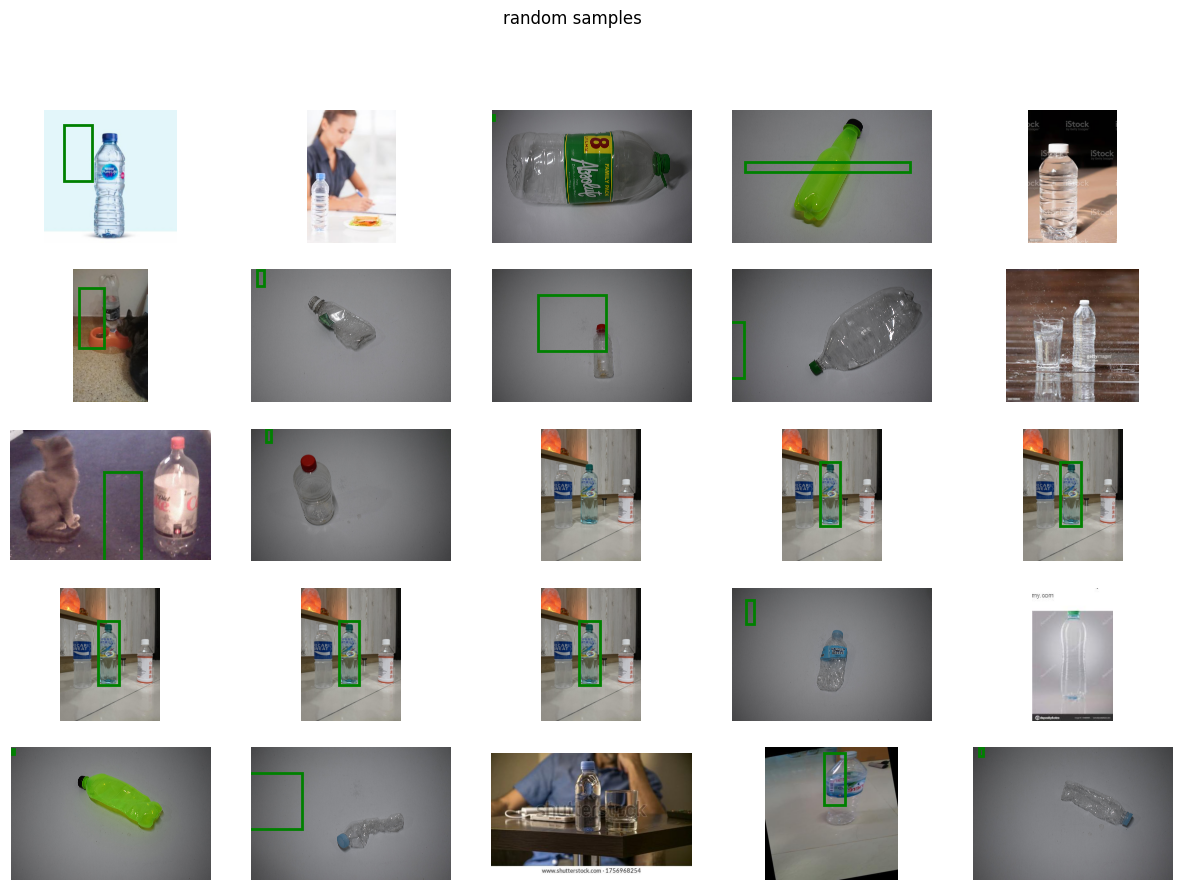

In [12]:
samples = torch.randperm(len(images))
nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))

for i in range(nrows):
    for j in range(ncols):
        img = Image.open(os.path.join(train_images_dir, images[samples[i] + j]))
        axs[i, j].imshow(img)
        rect = Rectangle((x_min, y_min), width, height, edgecolor="green", fill=False, linewidth=2)
        x_min, x_max, y_min, y_max, width, height = labels_df[labels_df["image_id"] == images[samples[i] + j]][["x_min", "x_max", "y_min","y_max", "width", "height"]].values.tolist()[0]
        axs[i,j].add_patch(rect)
        axs[i, j].axis(False)
        
plt.suptitle("random samples")